In [51]:
#import modules
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdna
import numpy as np
from scipy.stats import zscore
import gc
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon, mapping


In [52]:
#Import graphml, convert to undirected
graphml_path = "belfast_gb_2019_10000m_all_osm_20190902.graphml"
G = ox.load_graphml(graphml_path)
G_undirected = ox.save_load.get_undirected(G)
gdf_osm = ox.save_load.graph_to_gdfs(G_undirected, nodes=False, edges=True)


In [53]:
osm_buffer_file="belfast_gb_2019_1600m_buffer.gpkg"
gdf_study_area = gpd.read_file(osm_buffer_file, layer='urban_study_region')

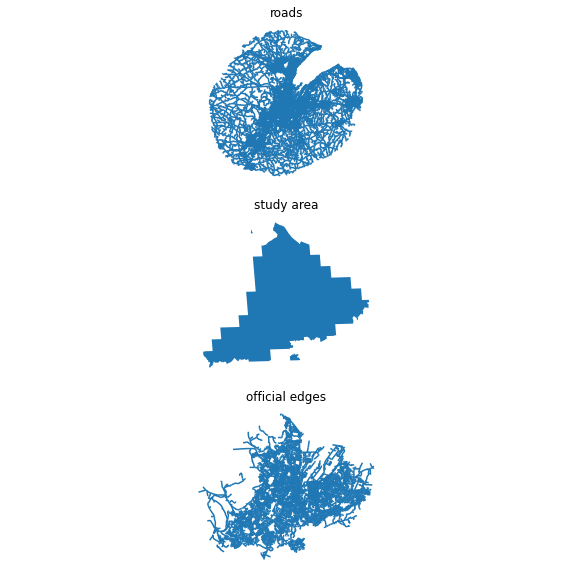

In [54]:
#pdf_study_area = gpd.read_file(graphml_path, layer='urban_study_region')
gdf_official = gpd.GeoDataFrame.from_file("Belfast_City_Council_Area_Street_Network.shp")
gdf_osm = gdf_osm.to_crs(gdf_official.crs)
gdf_study_area = gdf_study_area.to_crs(gdf_official.crs)

fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
gdf_osm.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
gdf_official.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [ ]:
#Import boundaries


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the ol

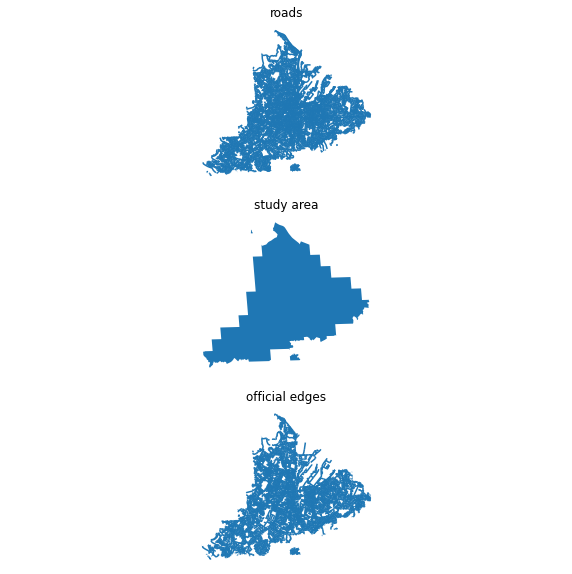

In [55]:
#Clip datasets by boundaries
#mask1 = gdf_osm['geometry'].intersects(gdf_study_area['geometry'].unary_union)
osm_data = gpd.clip(gdf_osm, gdf_study_area)
#mask2 = gdf_official['geometry'].intersects(gdf_study_area['geometry'].unary_union)
official_data = gpd.clip(gdf_official, gdf_study_area)

fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
osm_data.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
official_data.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [56]:
#Calculating the total length
totallength = 0
count_osm = 0 
osmlength = osm_data.length
for i in osmlength:
    count_osm += 1
    totallength += i
print(totallength, count_osm)

1700228.419254998 26244


In [57]:
totallength2 = 0
count_of = 0 
oflength = official_data.length
for i in oflength:
    count_of += 1
    totallength2 += i
print(totallength2, count_of)

1330205.3149234927 18662


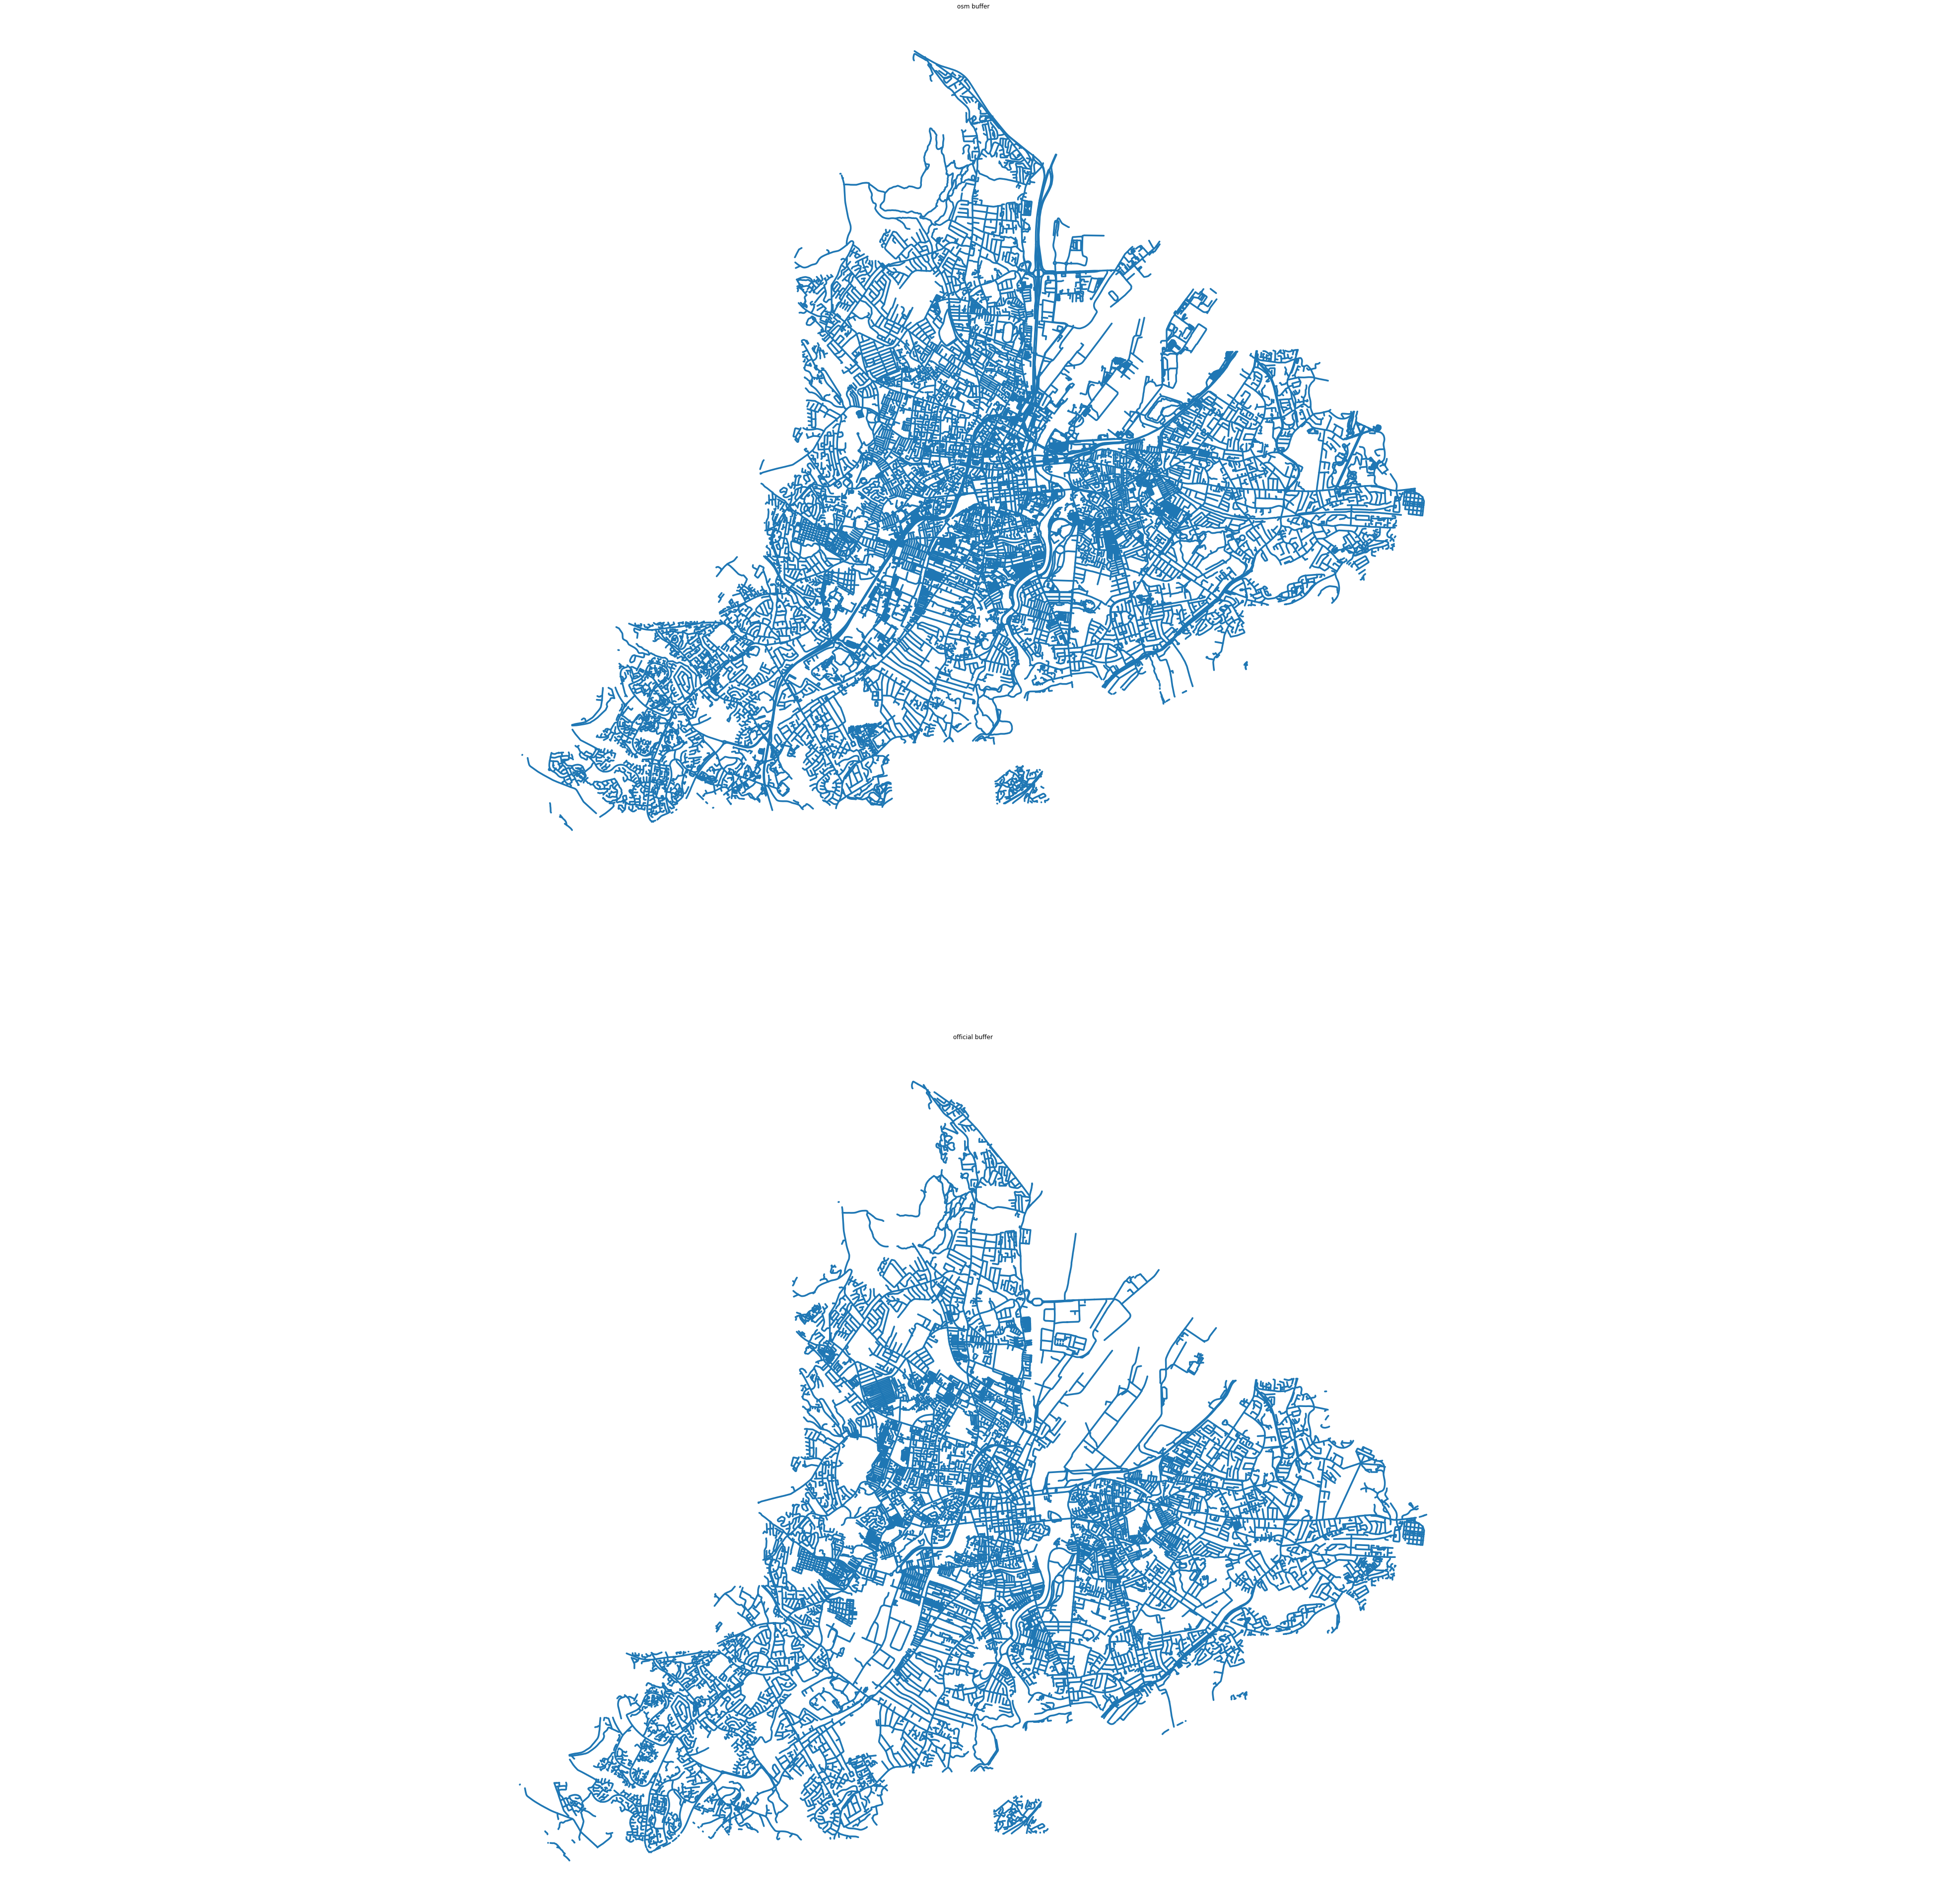

In [40]:
#buffering 
official_buffer = official_data
official_buffer['geometry'] = official_buffer.buffer(5)

osm_buffer = osm_data
osm_buffer['geometry'] = osm_buffer.buffer(5)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=( 70, 70))
osm_buffer.plot(ax=ax1)
official_buffer.plot(ax=ax2)

ax1.set_title("osm buffer")
ax2.set_title("official buffer")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

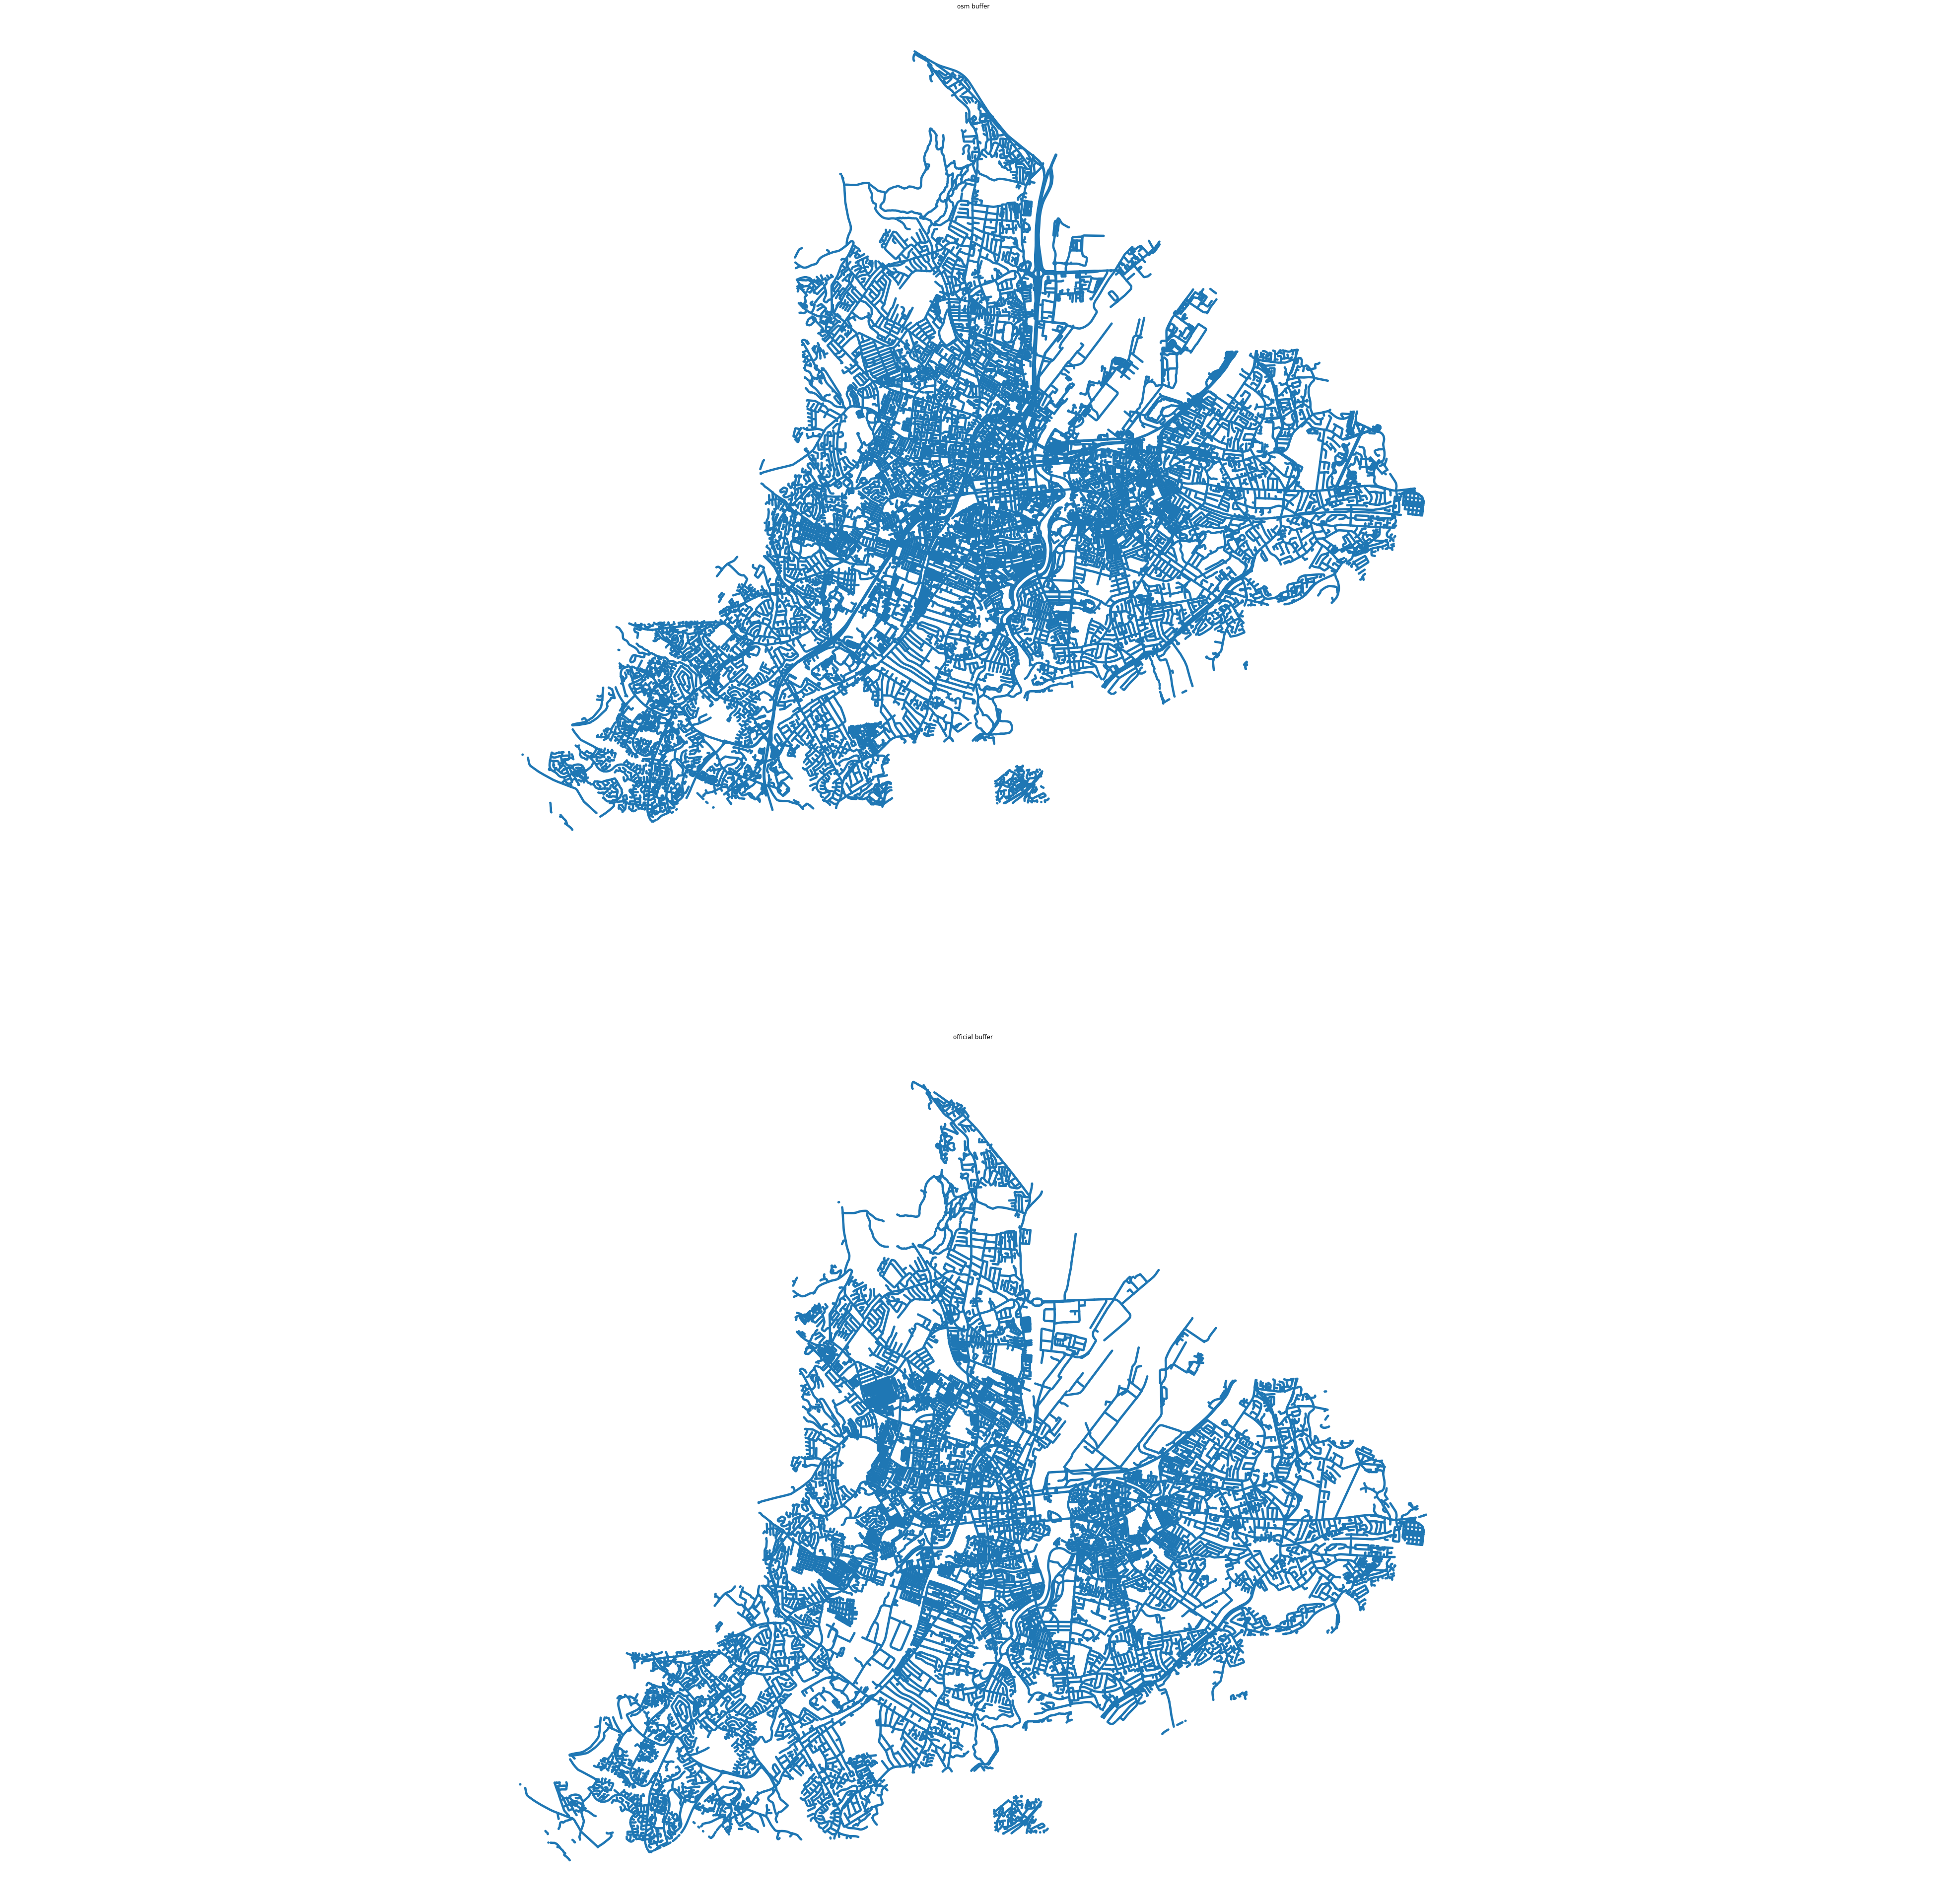

In [44]:
official_buffer = official_data
official = official_buffer.buffer(5)

osm_buffer = osm_data
osm= osm_buffer.buffer(5)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=( 70, 70))
osm.plot(ax=ax1)
official.plot(ax=ax2)

ax1.set_title("osm buffer")
ax2.set_title("official buffer")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

In [45]:
osm.head()


0     POLYGON ((333664.089 380067.402, 333664.212 38...
1     POLYGON ((333686.041 380075.390, 333685.459 38...
2     POLYGON ((333738.832 380090.050, 333738.832 38...
9     POLYGON ((333787.794 379922.079, 333791.206 37...
10    POLYGON ((333746.559 380038.746, 333746.560 38...
dtype: geometry

In [60]:
#Calculated areal intersections with various buffers
buff = 5
percent_list = []
percent_dict = {}
while buff<20:
    
    
    official_buffer = official_data
    official_buffer = official_buffer.buffer(buff)

    osm_buffer = osm_data
    osm_buffer = osm_buffer.buffer(buff)

    
    osm_total = 0
    osm_areas = osm_buffer.area
    for i in osm_areas:
        osm_total += i
    print(osm_areas[0:3])
    
    official_total = 0
    official_areas = official_buffer.area
    for i in official_areas:
        official_total += i
    print(official_areas[0:3])
    print(osm_total, official_total)
    
    intersected = osm_buffer.difference(official_buffer.unary_union)
    totalshare = 0
    in_areas = intersected.area
    for i in in_areas:
        totalshare += i
    print(totalshare)
    percent_official_intersected = totalshare*100/official_total
    
    percent_dict[buff] = percent_official_intersected
    percent_list.append((buff,percent_official_intersected))
    buff += 5
    
   

0     696.584400
1     569.366282
2    1085.491755
dtype: float64
0    3719.822525
1    1467.581457
2    1209.023482
dtype: float64
19034504.29251462 14763241.83523852
6635372.9166052295
0    1549.996224
1    1295.559458
2    2327.370782
dtype: float64
0    7596.471067
1    3091.987264
2    2574.871133
dtype: float64
42114182.29836782 32439029.046362787
11599701.328762123
0    2560.235473
1    2178.579528
2    3725.637081
dtype: float64
0    11629.945627
1     4873.217423
2     4097.542953
dtype: float64
69234382.28524312 53015213.99517314
15993732.194937909


In [61]:
print(percent_list)

[(5, 44.94522944660566), (10, 35.75847264782031), (15, 30.16819322165536)]
